In [ ]:
!pip install torch torchvision torchaudio tqdm scikit-learn joblib

import os, glob, cv2, joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### **Extract Feature Function**

In [ ]:
def extract_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read {img_path}")
        return None

    brightness = img.mean()
    contrast = img.std()

    edges = cv2.Canny(img, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size
    edge_var = np.var(edges)

    # Entropy (how complex the image is)
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    hist = hist / hist.sum()
    entropy = -np.sum([p * np.log2(p) for p in hist if p != 0])

    return [brightness, contrast, edge_density, edge_var, entropy]

### **Training ML**

In [ ]:

# ==== PATHS ====
base_dir = "/content/drive/My Drive/Colab Notebooks/Project_images"
folders = {
    "good_pic": {"good_for_ocr": 1, "has_picture": 1},
    "bad_pic": {"good_for_ocr": 0, "has_picture": 1},
    "bad_no_pic": {"good_for_ocr": 0, "has_picture": 0},
    "good_no_pic": {"good_for_ocr": 1, "has_picture": 0}
}

# ==== BUILD DATASET ====
data = []
for folder_name, labels in folders.items():
    folder_path = os.path.join(base_dir, folder_name)
    print(f"Processing folder: {folder_name}")
    for img_path in tqdm(glob.glob(os.path.join(folder_path, "*.jpg"))):
        f = extract_features(img_path)
        if f:
            data.append(f + [labels["good_for_ocr"], labels["has_picture"]])

df = pd.DataFrame(data, columns=[
    "brightness","contrast","edge_density","edge_var","entropy",
    "good_for_ocr","has_picture"
])
df.to_csv(os.path.join(base_dir, "features.csv"), index=False)
print("Feature dataset saved!")


# ===============================
# RANDOM FOREST
# ===============================
X = df[["brightness","contrast","edge_density","edge_var","entropy"]].values
y_pic = df["has_picture"].values

model_pic = RandomForestClassifier(n_estimators=100, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_pic = cross_val_score(model_pic, X, y_pic, cv=kf, scoring='accuracy')

rf_acc = round(scores_pic.mean(), 3)
print("\n RandomForest Picture-detection CV accuracy:", rf_acc)

model_pic.fit(X, y_pic)
joblib.dump(model_pic, os.path.join(base_dir, "picture_detection_RF.pkl"))


# ===============================
# CNN PIPELINE
# ===============================
class PageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        for label, folder in enumerate(["good_no_pic", "bad_no_pic", "good_pic", "bad_pic"]):
            folder_path = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_path):
                if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                    if folder in ["good_pic", "bad_pic"]:
                      has_pic = 1
                    else:
                      has_pic = 0
                    self.samples.append((os.path.join(folder_path, fname), has_pic))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


def create_model(num_classes=2):
    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


def train_cnn_kfold(dataset, k_folds=5, num_epochs=5, batch_size=8, lr=1e-4, device="cuda" if torch.cuda.is_available() else "cpu"):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    fold_acc = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\n Fold {fold+1}/{k_folds}")
        train_sub = Subset(dataset, train_idx)
        val_sub = Subset(dataset, val_idx)
        train_loader = DataLoader(train_sub, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=batch_size, shuffle=False)

        model = create_model().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                out = model(imgs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            print(f"  Loss: {total_loss / len(train_loader):.4f}")

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                _, preds = torch.max(out, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = correct / total
        print(f" Fold {fold+1} Accuracy: {acc*100:.2f}%")
        fold_acc.append(acc)
        torch.save(model.state_dict(), os.path.join(base_dir, f"cnn_fold{fold+1}.pth"))

    avg_acc = np.mean(fold_acc)
    print(f"\n CNN Avg K-Fold Accuracy: {avg_acc*100:.2f}%")
    return avg_acc


# ===============================
# RUN CNN K-FOLD
# ===============================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

cnn_dataset = PageDataset(base_dir, transform=transform)
cnn_acc = train_cnn_kfold(cnn_dataset, k_folds=5, num_epochs=5)

# ===============================
# COMPARE RESULTS
# ===============================
print("\n==============================")
print("MODEL COMPARISON RESULTS")
print(f"RandomForest Accuracy: {rf_acc*100:.2f}%")
print(f"EfficientNet Accuracy: {cnn_acc*100:.2f}%")
print("==============================")


Processing folder: good_pic


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Processing folder: bad_pic


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


Processing folder: bad_no_pic


100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Processing folder: good_no_pic


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Feature dataset saved!

 RandomForest Picture-detection CV accuracy: 0.76


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Fold 1/5
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 170MB/s]
Epoch 1/5: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


  Loss: 0.6693


Epoch 2/5: 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


  Loss: 0.4489


Epoch 3/5: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


  Loss: 0.3137


Epoch 4/5: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]


  Loss: 0.2089


Epoch 5/5: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


  Loss: 0.2022
 Fold 1 Accuracy: 92.86%

 Fold 2/5


Epoch 1/5: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


  Loss: 0.6078


Epoch 2/5: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


  Loss: 0.4299


Epoch 3/5: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


  Loss: 0.3538


Epoch 4/5: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


  Loss: 0.3170


Epoch 5/5: 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]


  Loss: 0.1727
 Fold 2 Accuracy: 100.00%

 Fold 3/5


Epoch 1/5: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


  Loss: 0.6587


Epoch 2/5: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


  Loss: 0.4658


Epoch 3/5: 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


  Loss: 0.3519


Epoch 4/5: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


  Loss: 0.2876


Epoch 5/5: 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


  Loss: 0.2142
 Fold 3 Accuracy: 92.31%

 Fold 4/5


Epoch 1/5: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]


  Loss: 0.6524


Epoch 2/5: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


  Loss: 0.4412


Epoch 3/5: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


  Loss: 0.3125


Epoch 4/5: 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


  Loss: 0.2610


Epoch 5/5: 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


  Loss: 0.1692
 Fold 4 Accuracy: 100.00%

 Fold 5/5


Epoch 1/5: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


  Loss: 0.6739


Epoch 2/5: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


  Loss: 0.4787


Epoch 3/5: 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


  Loss: 0.3454


Epoch 4/5: 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


  Loss: 0.2426


Epoch 5/5: 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


  Loss: 0.1997
 Fold 5 Accuracy: 100.00%

 CNN Avg K-Fold Accuracy: 97.03%

MODEL COMPARISON RESULTS
RandomForest Accuracy: 76.00%
EfficientNet Accuracy: 97.03%


### **ML MODEL COMPARISON**

In [ ]:
# =============================================
# MODEL COMPARISON
# =============================================
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "KNN": KNeighborsClassifier(n_neighbors=4),
    "SVM": SVC(kernel="rbf", gamma="scale"),
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

eval_acc = {}


for name, model in models.items():
    scores = cross_val_score(model, X, y_pic, cv=kf, scoring='accuracy')
    acc = scores.mean()
    eval_acc[name] = acc
    print(f"{name}: {acc*100:.2f}%")

# Make a DataFrame for a clean summary table
results_df = pd.DataFrame({
    "Model": list(eval_acc.keys()),
    "Accuracy ": [f"{v*100:.2f}%" for v in eval_acc.values()]
})


KNN: 72.86%
SVM: 71.21%
Logistic Regression: 72.64%
Random Forest: 76.04%


### **TEST**

In [ ]:
def load_test_set(test_dir):
    X_test = []
    y_test = []

    # has picture = 1
    for img_path in glob.glob(os.path.join(test_dir, "pic", "*")):
        f = extract_features(img_path)
        if f:
            X_test.append(f)
            y_test.append(1)

    # no picture = 0
    for img_path in glob.glob(os.path.join(test_dir, "no_pic", "*")):
        f = extract_features(img_path)
        if f:
            X_test.append(f)
            y_test.append(0)

    return np.array(X_test), np.array(y_test)

# Example:
X_test, y_test = load_test_set("/content/drive/MyDrive/Colab Notebooks/Project_images/test_images")


In [ ]:
from sklearn.metrics import accuracy_score
real_test_results = {}

for name, model in models.items():
    # เทรนด้วย train set ทั้งหมด
    model.fit(X, y_pic)

    # ทำนาย test set
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    real_test_results[name] = acc
    print(f"{name} Real Testing Accuracy: {acc*100:.2f}%")

KNN Real Testing Accuracy: 47.50%
SVM Real Testing Accuracy: 47.50%
Logistic Regression Real Testing Accuracy: 47.50%
Random Forest Real Testing Accuracy: 55.00%


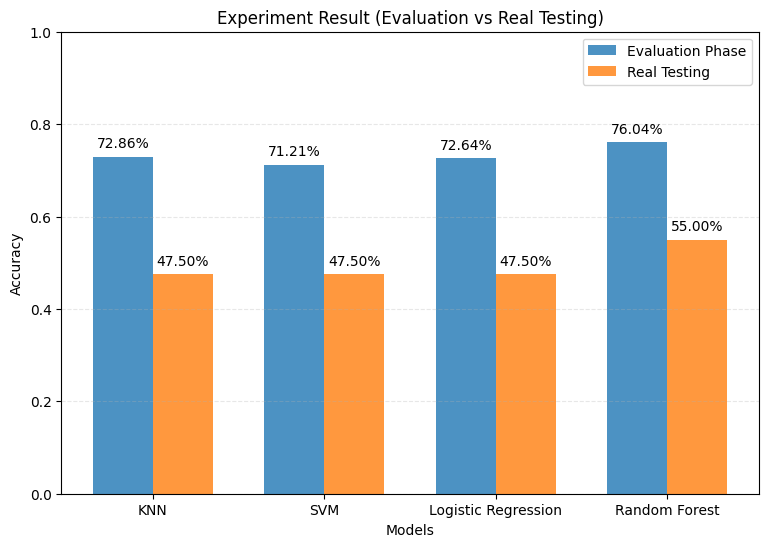

In [ ]:
models_list = list(eval_acc.keys())
eval_values = [eval_acc[m] for m in models_list]
real_values = [real_test_results[m] for m in models_list]

x = np.arange(len(models_list))
width = 0.35

plt.figure(figsize=(9, 6))
plt.bar(x - width/2, eval_values, width, label='Evaluation Phase', alpha=0.8)
plt.bar(x + width/2, real_values, width, label='Real Testing', alpha=0.8)

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Experiment Result (Evaluation vs Real Testing)")
plt.xticks(x, models_list)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

for i, v in enumerate(eval_values):
    plt.text(x[i] - width/2, v + 0.02, f"{v*100:.2f}%", ha='center', fontsize=10)

for i, v in enumerate(real_values):
    plt.text(x[i] + width/2, v + 0.02, f"{v*100:.2f}%", ha='center', fontsize=10)

plt.show()


### **Load Models**

In [ ]:
def load_models(base_dir):
    # Load RandomForest model
    rf_model = joblib.load(os.path.join(base_dir, "picture_detection_RF.pkl"))

    # Load CNN model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    cnn_model = models.efficientnet_b0(weights=None)
    cnn_model.classifier[1] = torch.nn.Linear(cnn_model.classifier[1].in_features, 2)
    latest_model = os.path.join(base_dir, "cnn_fold5.pth")  # or auto-select newest
    cnn_model.load_state_dict(torch.load(latest_model, map_location=device))
    cnn_model.to(device)
    cnn_model.eval()

    return rf_model, cnn_model, device

### **Predict Image Function**

In [ ]:
def predict_image(img_path, rf_model, cnn_model, device):
    # RandomForest prediction
    features = extract_features(img_path)
    features = np.array(features).reshape(1, -1)  # shape (1,5)
    rf_pred = int(rf_model.predict(features)[0])  # 0 or 1
    print(f"RandomForest: {'HAS embedded image' if rf_pred == 1 else 'CLEAN text page'}")

    # CNN prediction
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])

    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = cnn_model(tensor)
        cnn_pred = int(torch.argmax(output, 1).item())
    print(f"CNN: {'HAS embedded image' if cnn_pred == 1 else 'CLEAN text page'}")

    return rf_pred, cnn_pred

In [ ]:
def process_for_ocr(img_path, rf_model, cnn_model, device, save_path=None):
    rf_pred, cnn_pred = predict_image(img_path, rf_model, cnn_model, device)

    # If either model detects an embedded image → mask it
    if cnn_pred == 1 or rf_pred == 1:
        print("⚠️ WARNING: Embedded image or bad quality detected.")
        print("OCR accuracy and TTS output may not be ideal.")
    else:
        print("✅ Page seems clean and suitable for OCR.")

    return cv2.imread(img_path)

RandomForest: CLEAN text page
CNN: HAS embedded image
⚠️ WARNING: Embedded image or bad quality detected.
OCR accuracy and TTS output may not be ideal.


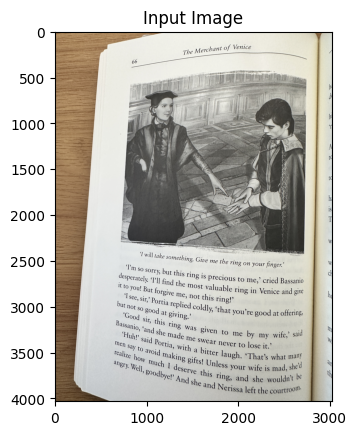

In [ ]:
base_dir = "/content/drive/My Drive/Colab Notebooks/Project_images"
rf_model, cnn_model, device = load_models(base_dir)

input_image = "/content/drive/My Drive/Colab Notebooks/Project_images/test_images/pic/IMG_8336.JPG"


input_img = cv2.imread(input_image)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.title("Input Image")
plt.imshow(input_img)

final_img = process_for_ocr(input_image, rf_model, cnn_model, device)

In [ ]:
import os
import glob
import numpy as np
from sklearn.metrics import accuracy_score

# ใช้ transform แบบเดียวกับ predict_image()
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

def test_cnn_on_folder(test_dir, cnn_model, device):
    y_true = []
    y_pred = []

    # รูปที่มีภาพ → label 1
    for img_path in glob.glob(os.path.join(test_dir, "pic", "*")):
        img = Image.open(img_path).convert("RGB")
        tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = cnn_model(tensor)
            pred = int(torch.argmax(output, 1).item())

        y_true.append(1)
        y_pred.append(pred)

    # รูปที่ไม่มีภาพ → label 0
    for img_path in glob.glob(os.path.join(test_dir, "no_pic", "*")):
        img = Image.open(img_path).convert("RGB")
        tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = cnn_model(tensor)
            pred = int(torch.argmax(output, 1).item())

        y_true.append(0)
        y_pred.append(pred)

    # คำนวณ Accuracy
    acc = accuracy_score(y_true, y_pred)
    return acc, y_true, y_pred


# ▶ RUN TESTING
test_dir = "/content/drive/My Drive/Colab Notebooks/Project_images/test_images"
cnn_acc_real, y_true, y_pred = test_cnn_on_folder(test_dir, cnn_model, device)

print(f"CNN Real Testing Accuracy: {cnn_acc_real*100:.2f}%")


CNN Real Testing Accuracy: 80.00%
